In [18]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules import chipmultilabel
from earthtext.datamodules.components.chipmultilabel import embeddings_mean
from importlib import reload
reload(chipmultilabel)

<module 'earthtext.datamodules.chipmultilabel' from '/home/ubuntu/earth-text/src/earthtext/datamodules/chipmultilabel.py'>

In [16]:
def plot_chip(batch, idx):
    b = batch
    c = b['chip'][idx][:3].detach().numpy()
    c = np.transpose(c, [1,2,0]).astype(float)
    _,vmax = np.percentile(c, [5,99])
    c /= vmax
    c[c>1]=1
    plt.axis('off')
    plt.imshow(c)

    n_osmobjects = b['osm_ohecount'][idx].numpy().sum()
    total_osmarea = b['osm_ohearea'][idx].numpy().sum()
    total_osmlength = b['osm_ohelength'][idx].numpy().sum()

    plt.title(f"chip {idx}\nosm count {n_osmobjects}\nosm area {total_osmarea:.2f}\nosm length {total_osmlength:.2f}")

In [2]:
#conf = OmegaConf.load("../../configs/osmencoder-abs-logrsme-1epoch.yaml")
conf = OmegaConf.load("../../configs/osmencoder-x.yaml")

In [4]:
conf.dataloader['substract_embeddings_mean'] = False

{'_target_': 'earthtext.datamodules.chipmultilabel.ChipMultilabelModule', 'metadata_file': '/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels.parquet', 'embeddings_folder': '/opt/data/california-worldcover-chips/embeddings_v0.2', 'chips_folder': '/opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips', 'get_osm_strlabels': True, 'get_osm_ohearea': True, 'get_osm_ohecount': True, 'get_osm_ohelength': True, 'substract_embeddings_mean': False, 'abs_embeddings': False, 'norm_embeddings': False, 'multilabel_threshold_osm_ohecount': 1}

In [7]:
dl = hydra.utils.instantiate(conf.dataloader)
dl.enable_chip_loading()

2024-04-16 03:19:37.220 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:278 - checking chip files for train split
100% (60396 of 60396) |##################| Elapsed Time: 0:00:05 Time:  0:00:050000
2024-04-16 03:19:42.963 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:282 - read train split with 60295 chip files (out of 60396)
2024-04-16 03:19:42.964 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:284 - max cache size is -1
2024-04-16 03:19:44.214 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:278 - checking chip files for val split
100% (12304 of 12304) |##################| Elapsed Time: 0:00:01 Time:  0:00:010000
2024-04-16 03:19:45.380 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:282 - read val split with 12288 chip files (out of 12304)
2024-04-16 03:19:45.380 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:284 - max cache size is -1
2024-04-16 03:

In [8]:
b = next(iter(dl.train_dataloader()))


In [11]:
{k:v.shape if type(v) is not list else len(v) for k,v in b.items()}

{'multilabel': torch.Size([16, 99]),
 'chip': torch.Size([16, 6, 256, 256]),
 'embedding': torch.Size([16, 768]),
 'osm_strlabels': 16,
 'osm_ohearea': torch.Size([16, 99]),
 'osm_ohecount': torch.Size([16, 99]),
 'osm_ohelength': torch.Size([16, 99])}

In [14]:
tr_targets = b['embedding']

In [22]:
def plot_embeddings_sim (batch, remove_mean = False):
    targets = batch['embedding']
    for ax,i in subplots(len(targets)//2 * 3, n_cols=9):
        idx1 = i//3
        idx2 = len(targets)//2+i//3
    
        if i%3==0:
            t1 = targets[idx1]
            t2 = targets[idx2]
            if remove_mean:
                t1 -= embeddings_mean
                t2 -= embeddings_mean
            plt.scatter(t1, t2, alpha=.2)
            plt.grid()
            plt.xlabel(f"clayv2 embeddings for chip {idx1}")
            plt.ylabel(f"clayv2 embeddings for chip {idx2}")
        elif i%3==1:
            plot_chip(batch, idx1)
        else:
            plot_chip(batch, idx2)

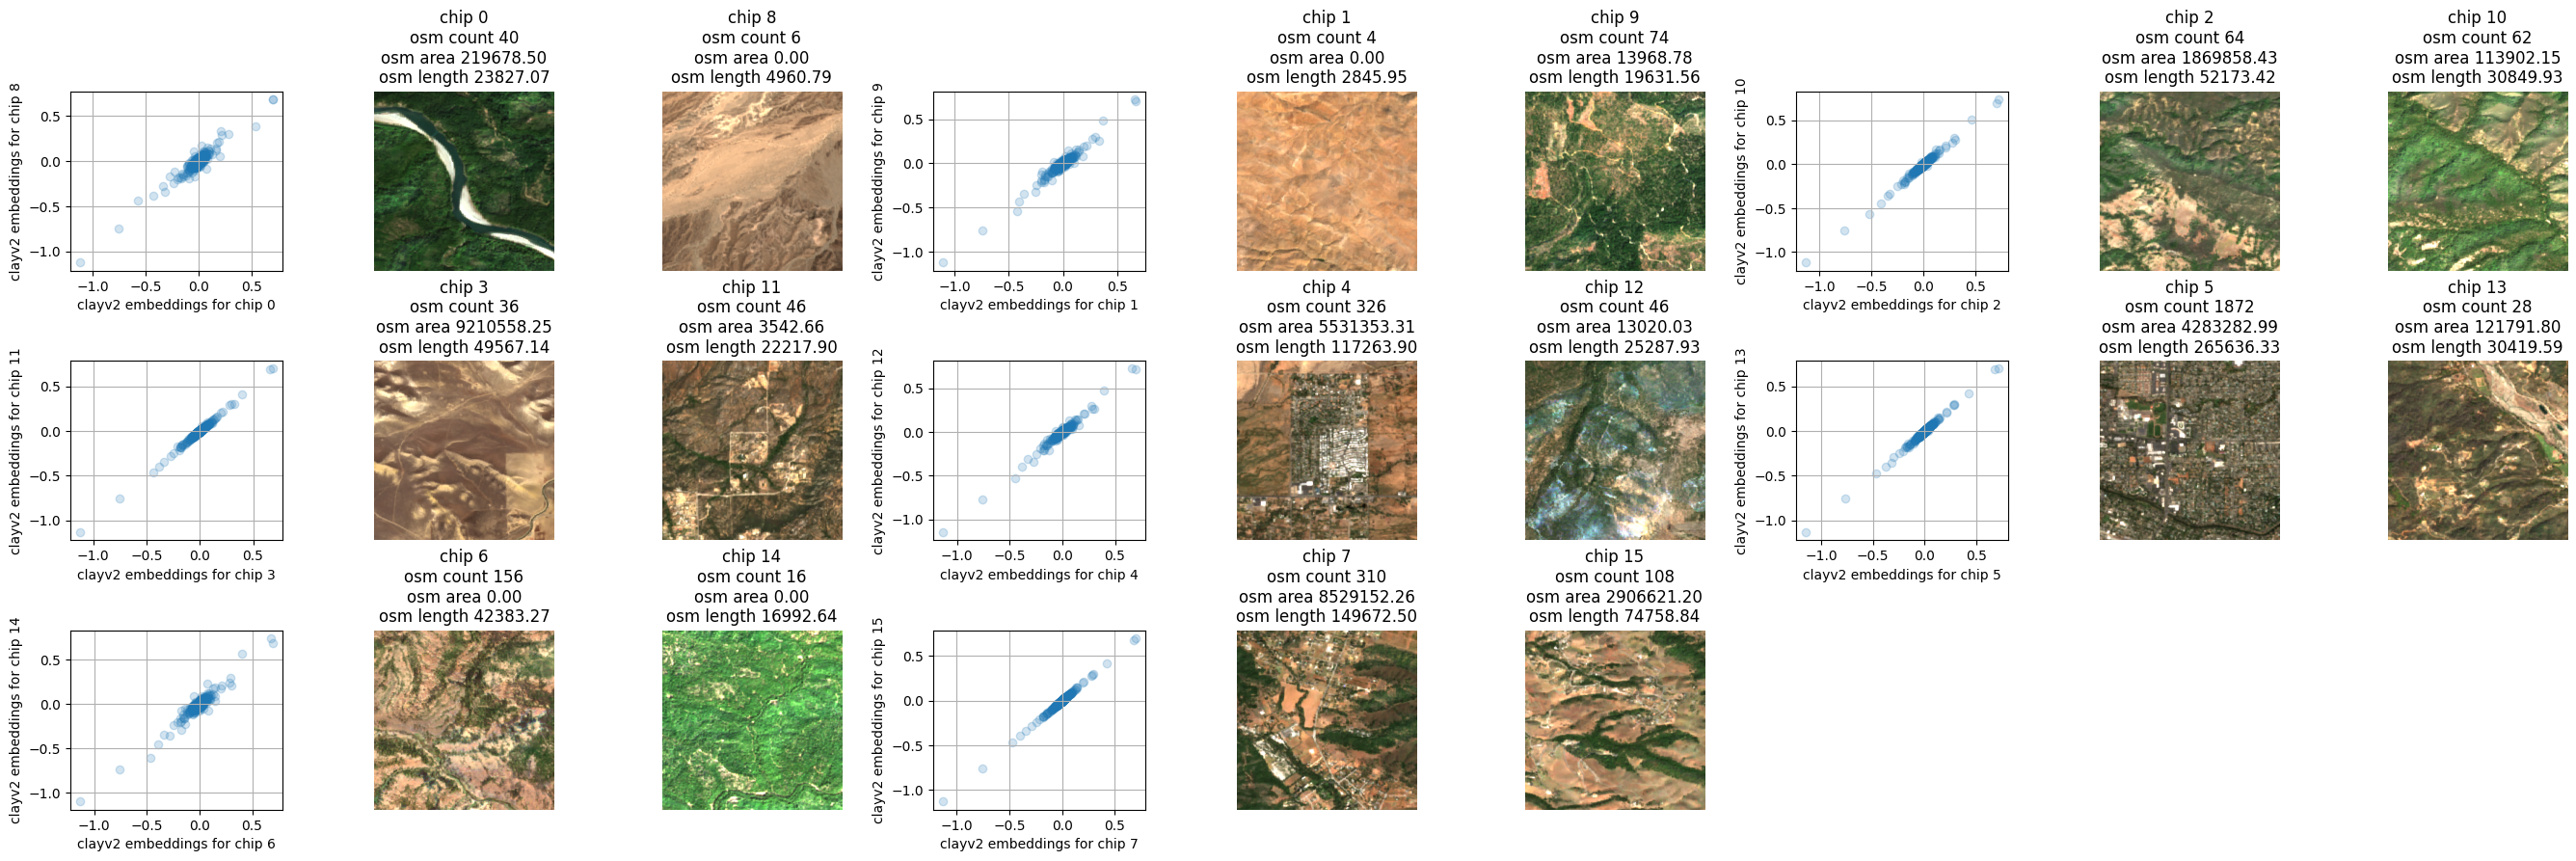

In [21]:
plot_embeddings_sim(b)

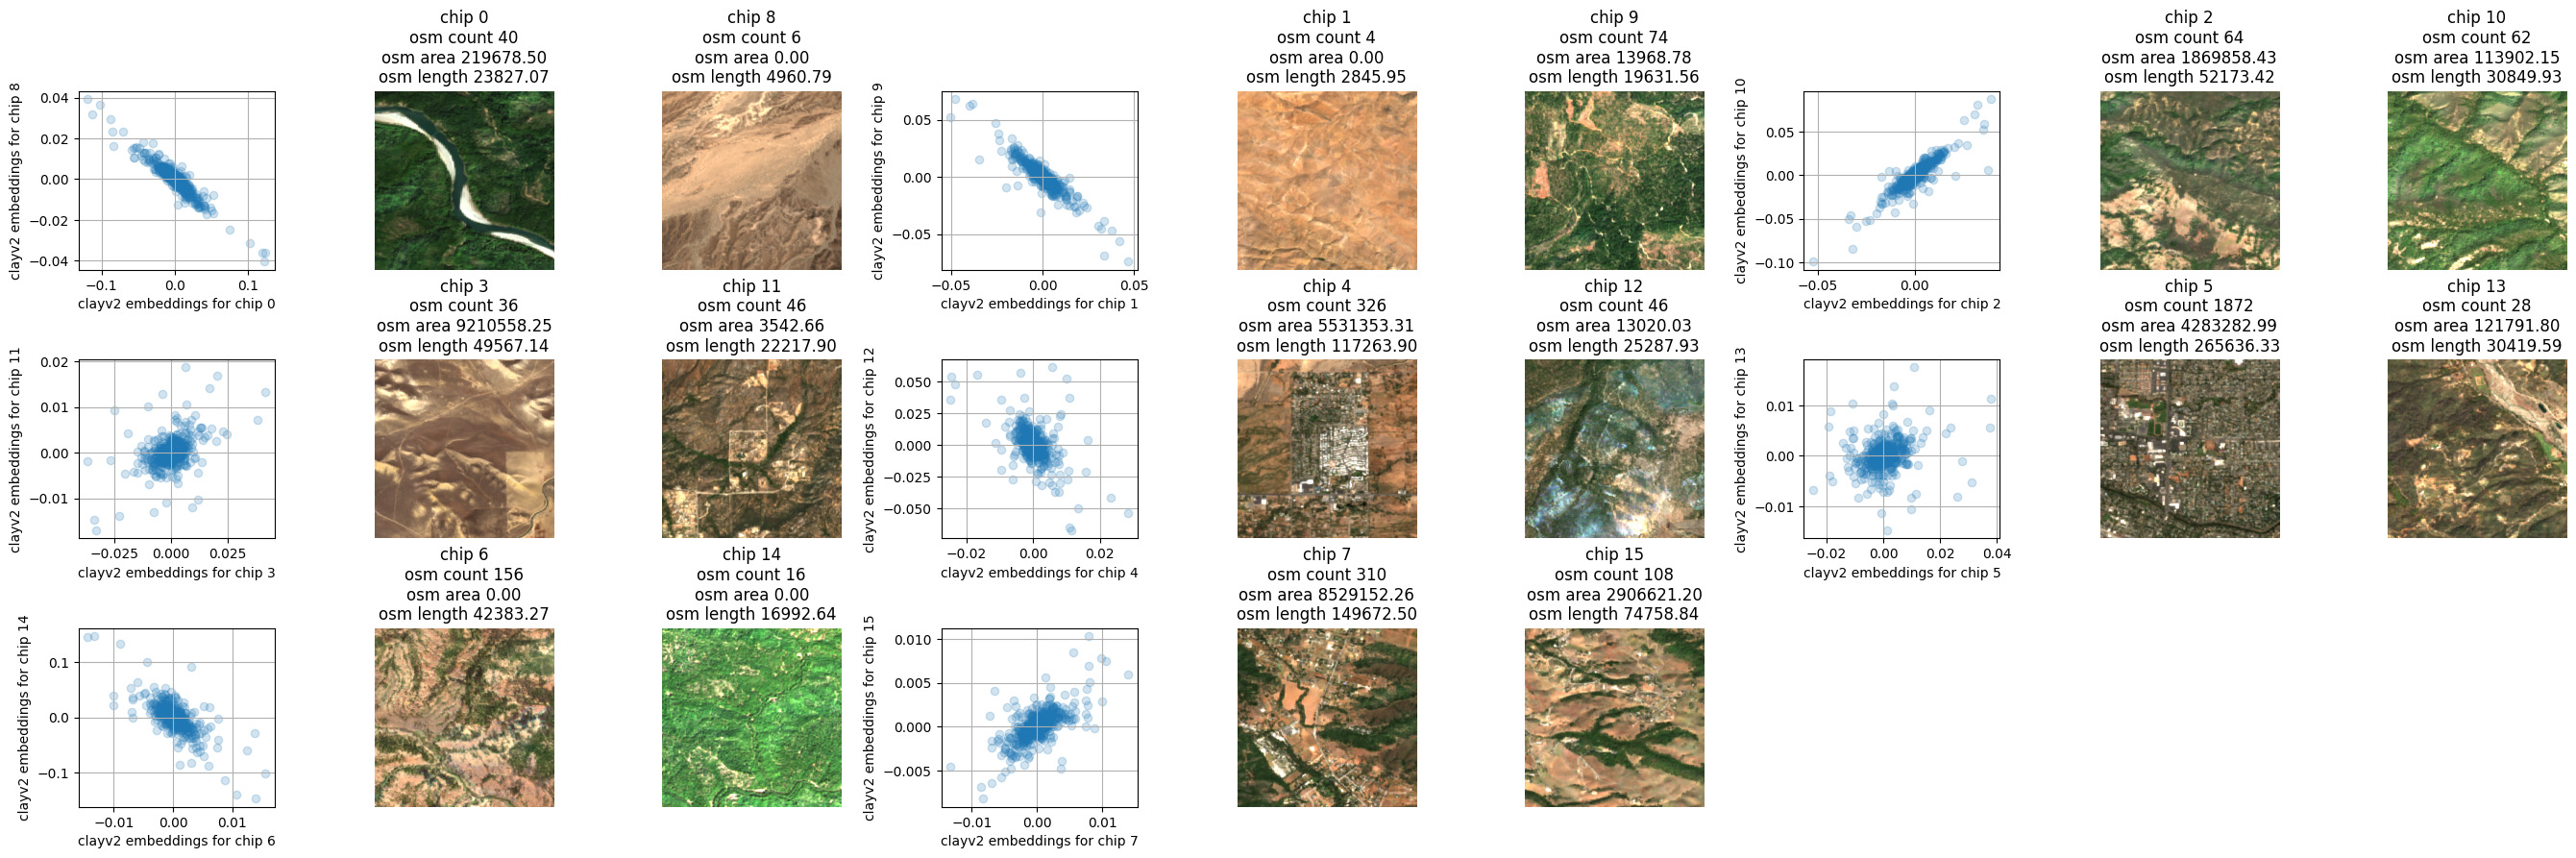

In [23]:
plot_embeddings_sim(b, remove_mean=True)